In [3]:
import pandas as pd

Index(['repeat_i', 'is_change_apply_to_test', 'classifier_name',
       'dataset_name', 'semantic_change', 'char_freq_range', 'test_acc',
       'test_f1', 'train_loss', 'test_loss', 'train_size', 'val_size',
       'test_size'],
      dtype='object')


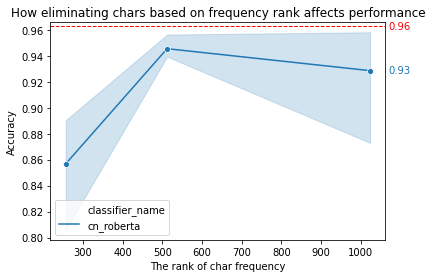

In [41]:
import pdb
import seaborn as sns
import matplotlib.pyplot as plt

# plot the trend when we changing only char freq

origin_df = pd.read_csv('../result/cn_novel_5billion_cn_roberta_None.csv')
all_range_acc = origin_df[origin_df['char_freq_range'] == 0]['test_acc'].mean()

origin_df = origin_df[origin_df['char_freq_range'] != 0]
print(origin_df.keys())
# print(origin_df)

plot_df = {'char_freq_range': [], 'value': [], 'type': [], 'classifier_name': []}
for char_freq_range, char_freq_df in origin_df.groupby('char_freq_range'):
    plot_df['classifier_name'].extend(char_freq_df['classifier_name'].values)
    plot_df['value'].extend(char_freq_df['test_acc'].values)
    plot_df['type'].extend(['acc' for _ in char_freq_df['test_acc'].values])
    plot_df['char_freq_range'].extend([char_freq_range for _ in char_freq_df['test_acc'].values])

plot_df = pd.DataFrame(plot_df)
# ci = confidence interval
ax = sns.lineplot(data=plot_df, x="char_freq_range", y="value", marker="o", hue='classifier_name')
ax.axhline(all_range_acc, ls='--', color='red', linewidth=1)
ax.set_title("How eliminating chars based on frequency rank affects performance")
ax.set(xlabel='The rank of char frequency', ylabel='Accuracy')

annotate_lines = ax.lines
for l in annotate_lines:
    y = l.get_ydata()
    if len(y)>0:
        ax.annotate(f'{y[-1]:.2f}', xy=(1.01,y[-1]), xycoords=('axes fraction', 'data'), 
                     ha='left', va='center', color=l.get_color())
plt.show()

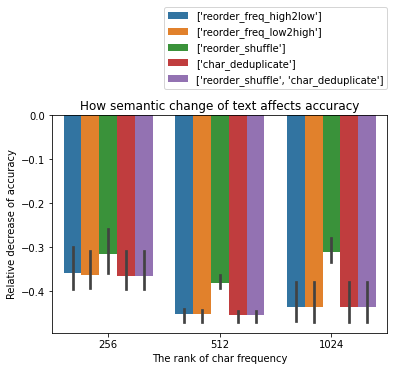

In [37]:
import os
import glob
import pdb

all_files = glob.glob(os.path.join('../result/', '*.csv'))
all_df = pd.concat([pd.read_csv(x) for x in all_files])
is_change_apply_to_test = False
# print(all_df['is_change_apply_to_test'])

all_df = all_df[all_df['is_change_apply_to_test'] == is_change_apply_to_test]
all_df = all_df[all_df['classifier_name']=='cn_roberta'] # filter non-pretrain models
# print(other_df['semantic_change'].values)

plot_df = {'char_freq_range': [], 
           'acc':[], 
           'origin_acc': [], 
           'relative_improve': [], 
           'type': [], 
           'semantic_change': []}

for char_freq_range, char_freq_df in all_df.groupby('char_freq_range'):
    
    if char_freq_range == 0:
        continue
    
    origin_mask = (char_freq_df['char_freq_range'] == char_freq_range) & (char_freq_df['semantic_change'] == "['None']")
    origin_df = char_freq_df[origin_mask]
    other_df = char_freq_df[~origin_mask]
    
    for i, row in other_df.iterrows():
        test_acc = row['test_acc']
        semantic_change = row['semantic_change']
        repeat_i = row['repeat_i']
        origin_row_df = origin_df[origin_df['repeat_i'] == repeat_i]
        origin_acc = float(origin_row_df['test_acc'])
        
        relative_improve = test_acc - origin_acc
        
        plot_df['char_freq_range'].append(char_freq_range)
        plot_df['acc'].append(test_acc)
        plot_df['origin_acc'].append(origin_acc)
        plot_df['relative_improve'].append(relative_improve)
        plot_df['type'].append('acc')
        plot_df['semantic_change'].append(semantic_change)
    
plot_df = pd.DataFrame(plot_df)
ax = sns.barplot(data=plot_df, x="char_freq_range", y="relative_improve", hue="semantic_change")
ax.set_title("How semantic change of text affects accuracy")
ax.set(xlabel='The rank of char frequency', ylabel='Relative decrease of accuracy')
plt.legend(bbox_to_anchor=(1.0, 1.12), loc=4, borderaxespad=0.)
plt.show()